# Transformer code part

## Import Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
! python -m spacy download de
! pip install torchtext==0.6.0
from torchtext.data import Field, BucketIterator,TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     |████████████████████████████████| 14.9MB 8.8MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=7607191a923309d9251a98736c6dd3bd67f1dc10dd6f96f8eff6010a30e9a73e
  Stored in directory: /tmp/pip-ephem-wheel-cache-frz6tx8_/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 1.2MB 10.5MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


## Preparing Data

In [ ]:
spacy_deutsch = spacy.load('de')
spacy_english = spacy.load('en')

def tokenize_de(text):
    """Tokenizes German text:  
    """
    return [tok.text for tok in spacy_deutsch.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_english.tokenizer(text)]


SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Please import the file path by yourself below this cell

In [ ]:
train_dataset, val_dataset, test_dataset = TabularDataset.splits(
        path='Please import the file path by yourself', train='train.csv',
        validation='valid.csv', test='test.csv', format='csv',
        fields=[('src', SRC), ('trg', TRG)], skip_header = True)

print("What the dataset looks like:\n")
print(train_dataset[5])
print(train_dataset[5].__dict__.keys())
print(train_dataset[5].src,train_dataset[5].trg)


SRC.build_vocab(train_dataset)
TRG.build_vocab(train_dataset)
print(">> the number of words (or the length of dictionary) is : ", len(SRC.vocab))
print(">> the token of {} is {}".format("<pad>",SRC.vocab.stoi["<pad>"]))
print(">> the token of {} is {}".format(SRC.init_token,SRC.vocab.stoi[SRC.init_token]))
print(">> the token of {} is {}".format(SRC.eos_token,SRC.vocab.stoi[SRC.eos_token]))

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, val_dataset, test_dataset), 
     batch_size = BATCH_SIZE,
     sort_within_batch=True,
     sort_key = lambda x: len(x.src),
     device = device)

What the dataset looks like:

dict_keys(['src', 'trg'])
['let', "'s", 'put', 'this', 'money', 'aside', 'for', 'our', 'summer', 'trip', '.'] ['legen', 'wir', 'dieses', 'geld', 'für', 'unsere', 'sommerreise', 'beiseite', '.']
>> the number of words (or the length of dictionary) is :  13367
>> the token of <pad> is 1
>> the token of <sos> is 2
>> the token of <eos> is 3
tensor([[    2,   137,    10,    93,   246,     8,     3,     1,     1,     1,
             1],
        [    2,    18,  2786,    10,   244,   108,     4,     3,     1,     1,
             1],
        [    2,     6,    44,  1093,     4,     3,     1,     1,     1,     1,
             1],
        [    2,     6,    24,  1879,     4,     3,     1,     1,     1,     1,
             1],
        [    2,     7,  2058,   217,   190,     4,     3,     1,     1,     1,
             1],
        [    2,   123,  2027,    10,  1713,     4,     3,     1,     1,     1,
             1],
        [    2,    11,  4611,    10,  1410,     4,    

In [ ]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, val_dataset, test_dataset), 
     batch_size = BATCH_SIZE,
     sort_within_batch=True,
     sort_key = lambda x: len(x.src),
     device = device)

tensor([[    2,   137,    10,    93,   246,     8,     3,     1,     1,     1,
             1],
        [    2,    18,  2786,    10,   244,   108,     4,     3,     1,     1,
             1],
        [    2,     6,    44,  1093,     4,     3,     1,     1,     1,     1,
             1],
        [    2,     6,    24,  1879,     4,     3,     1,     1,     1,     1,
             1],
        [    2,     7,  2058,   217,   190,     4,     3,     1,     1,     1,
             1],
        [    2,   123,  2027,    10,  1713,     4,     3,     1,     1,     1,
             1],
        [    2,    11,  4611,    10,  1410,     4,     3,     1,     1,     1,
             1],
        [    2,     7,    19,     9,    76,  1354,     4,     3,     1,     1,
             1],
        [    2,    74,   924,    10,  1104,     4,     3,     1,     1,     1,
             1],
        [    2,    15,    10,    76,    51,   103,   771,     4,     3,     1,
             1],
        [    2,    89,    41,   123,   5

## Model Definition

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, hid_dim, dropout=0.1,max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, hid_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hid_dim, 2).float() * (-math.log(10000.0) / hid_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: (seq_len, batch_size, hid_dim)
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: (batch_size, seq_len)
    seq_k: (batch_size, seq_len)
    seq_len could be src_len or it could be target_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, quary_len = seq_q.size()
    batch_size, key_len = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # (batch_size, 1, key_len)
    return pad_attn_mask.expand(batch_size, quary_len, key_len)  # (batch_size, quary_len, key_len)

def get_attn_subsequence_mask(seq):
    '''
    seq: [batch_size, target_len]
    '''
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # Upper triangular matrix
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    # (batch_size, target_len, target_len)
    return subsequence_mask 

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x: [batch_size, seq_len, hid_dim]
        """
        # (batch_size, seq_len, pf_dim)
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        # (batch_size, seq_len, hid_dim)
        x = self.fc_2(x)
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    # hid_dim -> hid_dim
    def __init__(self, hid_dim, n_heads, dropout, device):
        super(MultiHeadAttention, self).__init__()
        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.W_Q = nn.Linear(hid_dim, hid_dim, bias=False)
        self.W_K = nn.Linear(hid_dim, hid_dim, bias=False)
        self.W_V = nn.Linear(hid_dim, hid_dim, bias=False)
        
        self.fc = nn.Linear(hid_dim, hid_dim, bias=False)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, attn_mask):
        '''
        query: (batch_size, quary_len, hid_dim]
        key: (batch_size, key_len, hid_dim]
        value: (batch_size, len_v(=key_len), hid_dim]
        attn_mask: (batch_size, seq_len, seq_len]
        '''
        residual, batch_size = query, query.size(0)
        # Q: (batch_size, n_heads, quary_len, hid_dim)
        # K: (batch_size, n_heads, key_len, hid_dim)
        # V: (batch_size, n_heads, key_len, hid_dim)

        Q = self.W_Q(query).view(batch_size, -1, self.n_heads, self.head_dim ).permute(0, 2, 1, 3)
        K = self.W_K(key).view(batch_size, -1, self.n_heads, self.head_dim ).permute(0, 2, 1, 3) 
        V = self.W_V(value).view(batch_size, -1, self.n_heads, self.head_dim ).permute(0, 2, 1, 3)
        
        # Create attention from Q and K 
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        if attn_mask is not None:
            energy = energy.masked_fill(attn_mask == 0, -1e10)
        # (batch_size, n_heads, query len, key_len)
        attention = torch.softmax(energy, dim = -1)

        # (batch_size, n_heads, query len, head_dim)
        context = torch.matmul(self.dropout(attention), V)

        # (batch_size, query len, n_heads, head_dim)
        context = context.permute(0, 2, 1, 3).contiguous()

        # (batch_size, quary_len, hid_dim)
        context = context.view(batch_size, -1, self.hid_dim)

        # (batch_size, quary_len, hid_dim)
        output = self.fc(context) 

        return output, attention

In [ ]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(hid_dim, ff_dim, bias=False),
            nn.ReLU(),
            nn.Linear(ff_dim, hid_dim, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: (batch_size, seq_len, hid_dim)
        '''
        residual = inputs
        output = self.fc(inputs)
        # (batch_size, seq_len, hid_dim)
        return nn.LayerNorm(hid_dim).cuda()(output + residual) 

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_self_attn = MultiHeadAttention(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, hid_dim]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        #self attention
        _source, _ = self.enc_self_attn(enc_inputs, 
                                     enc_inputs, 
                                     enc_inputs, 
                                     enc_self_attn_mask)
        # dropout and residual
        enc_inputs = self.self_attn_layer_norm(enc_inputs + self.dropout(_source))
        
        # positionwise ff
        _source = self.positionwise_feedforward(enc_inputs)
        # layer norm
        # (batch_size, source_len,hidden_dim)
        enc_outputs = self.ff_layer_norm(enc_inputs + self.dropout(_source))

        return enc_outputs

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super(DecoderLayer, self).__init__()
        self.self_attn_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_norm = nn.LayerNorm(hid_dim)
        self.ff_norm = nn.LayerNorm(hid_dim)

        # decoder self attention
        self.dec_self_attn = MultiHeadAttention(hid_dim, n_heads, dropout, device)
        # encoder decoder attention
        self.dec_enc_attn = MultiHeadAttention(hid_dim, n_heads, dropout, device)
        # self.pos_ffn = PoswiseFeedForwardNet()
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_inputs: (batch_size, target_len, hid_dim)
        enc_outputs: (batch_size, src_len, hid_dim)
        dec_self_attn_mask: (batch_size, target_len, target_len)
        dec_enc_attn_mask: (batch_size, target_len, src_len)
        '''

        # self attention = masked multi-head attention
        _dec_inputs, _ = self.dec_self_attn(dec_inputs, 
                                      dec_inputs, 
                                      dec_inputs, 
                                      dec_self_attn_mask)
        
        # ADD and Norm
        # (batch_size, target_len, hid_dim)
        dec_inputs = self.self_attn_norm(dec_inputs + self.dropout(_dec_inputs))
            
        # multi-head attention with encoder attention
        _dec_inputs, attention = self.dec_enc_attn(dec_inputs,
                                                   enc_outputs,
                                                   enc_outputs,
                                                   dec_enc_attn_mask)
        
        # ADD and Norm
        # (batch_size, target_len, hid_dim)
        dec_inputs = self.enc_attn_norm(dec_inputs + self.dropout(_dec_inputs))
                            
        # positionwise feedforward
        _dec_inputs = self.positionwise_feedforward(dec_inputs)
        
        # dropout, residual and layer norm
        output = self.ff_norm(dec_inputs + self.dropout(_dec_inputs))
        
        # output: (batch_size, target_len, hid_dim)
        # attention: (batch_size, n_heads, target_len, src_len)
        return output, attention


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 ff_dim, 
                 dropout,
                 device,
                 max_length = 5000):
        super(Encoder, self).__init__()
        self.device = device

        self.src_emb = nn.Embedding(input_dim, hid_dim)
        self.pos_emb = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  ff_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, enc_inputs, enc_mask):
        '''
        enc_inputs: (batch_size, source_len)
        enc_mask: (batch_size, 1, 1, source_len)
        '''
        batch_size, source_len = enc_inputs.shape[0] ,enc_inputs.shape[1]

        # (batch_size, source_len)
        pos = torch.arange(0, source_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # (batch_size, source_len, hid_dim)
        enc_inputs = self.dropout((self.src_emb(enc_inputs) * self.scale) + self.pos_emb(pos))
        
        for layer in self.layers:
            enc_inputs = layer(enc_inputs, enc_mask)
        
        # (batch_size, src_len, hid_dim)
        return enc_inputs

In [ ]:
class Decoder(nn.Module):
    def __init__(self,output_dim, 
                  hid_dim, 
                  n_layers, 
                  n_heads,
                  ff_dim,            
                  dropout,
                  device,
                 max_length = 100):
        super(Decoder, self).__init__()
        self.device = device
        self.dropout = nn.Dropout(dropout)

        self.tgt_emb = nn.Embedding(output_dim, hid_dim)
        # self.pos_emb = PositionalEncoding(hid_dim)
        self.pos_emb = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  ff_dim, 
                                                  dropout, 
                                                  device) 
                                    for _ in range(n_layers)])
        self.fc = nn.Linear(hid_dim, output_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, dec_inputs, enc_outputs, dec_mask, enc_mask):
        '''
        dec_inputs: (batch_size, target_len)
        enc_outputs: (batch_size, src_len, hid_dim)
        dec_mask: (batch_size, 1, target_len, target_len)
        enc_mask: (batch_size, 1, 1, src_len)
        '''
        batch_size,target_len = dec_inputs.shape[0],dec_inputs.shape[1]

        # (batch_size, target_len)
        pos = torch.arange(0, target_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #  (batch_size, target_len, hid_dim)
        dec_inputs = self.dropout((self.tgt_emb(dec_inputs) * self.scale) + self.pos_emb(pos))

        # dec_inputs: (batch_size, target_len, hid_dim)
        # attention: (batch_size, n_heads, target_len, src_len)
        for layer in self.layers:
            dec_inputs, attention = layer(dec_inputs, enc_outputs, dec_mask, enc_mask)
        
        #  (batch_size, target_len, output_dim)
        output = self.fc(dec_inputs)
        
        return output, attention


In [ ]:
class Transformer(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.s_pad = src_pad_idx
        self.t_pad = trg_pad_idx
        self.device = device

    def make_s_mask(self,source):
        """ Create mask for source
        :param source: (batch_size, source_len)
        """
        # return size: (batch_size, 1, 1, source_len)
        return (source != self.s_pad).unsqueeze(1).unsqueeze(2)
    
    def make_t_mask(self, target):
        """ Create mask for target
        :param target: (batch_size, target_len)
        """    
        # (batch_size, 1, 1, target_len)
        target_pad_mask = (target != self.t_pad).unsqueeze(1).unsqueeze(2)   
        target_len = target.shape[1]
        
        # (target_len, target_len)
        target_sub_mask = torch.tril(torch.ones((target_len, target_len), device = self.device)).bool()

        # (batch_size, 1, target_len, target_len)
        target_mask = target_pad_mask & target_sub_mask
        
        return target_mask

    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs: (batch_size, src_len)
        dec_inputs: (batch_size, target_len)
        '''
        # enc_mask: (batch_size, 1, 1, src_len)
        # dec_mask: (batch_size, 1, target_len, target_len)
        enc_mask = self.make_s_mask(enc_inputs)
        dec_mask = self.make_t_mask(dec_inputs)
        # print(enc_mask)
        # print(dec_mask)
  
        # enc_outputs: (batch_size, src_len, hid_dim)
        enc_outputs  = self.encoder(enc_inputs,enc_mask)
        
        # dec_outpus: (batch_size, target_len, hid_dim)
        # dec_enc_attn: (n_layers, batch_size, target_len, src_len)
        dec_outputs, dec_enc_attns = self.decoder(dec_inputs, enc_outputs, dec_mask, enc_mask)
        return dec_outputs, dec_enc_attns

## Training Model

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        # take source and target from batch
        source = batch.src
        target = batch.trg
        optimizer.zero_grad()

        # output: (batch_size, target_len-1, output_dim)
        # target: (batch_size, target_len)
        output, _ = model(source, target[:,:-1]) 
        
        # take the dim of output
        output_dim = output.shape[-1]
        
        # output: ((target_len - 1) * batch_size, output_dim)
        # target: ((target_len - 1) * batch_size)
        output = output.contiguous().view(-1, output_dim)
        target = target[:,1:].contiguous().view(-1)
        
        
        loss = criterion(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        if i != 0 and i % 1000 == 0:
            print(i," ",epoch_loss/i)
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch_size, target_len - 1, output_dim]
            #trg = [batch_size, target_len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch_size * target_len - 1, output_dim]
            #trg = [batch_size * target_len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
source_dim = len(SRC.vocab)
target_dim = len(TRG.vocab)

# Transformer Parameters
hid_dim = 256  # Embedding Size
ff_dim = 512 # FeedForward dimension
k_dim = v_dim = 256  # dimension of K(=Q), V
n_layers = 3  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention
clip = 1
dropout = 0.1

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


## Training and Validation Dataset Testing

In [ ]:
encoder = Encoder(source_dim, 
                  hid_dim, 
                  n_layers, 
                  n_heads, 
                  ff_dim, 
                  dropout,
                  device)
decoder = Decoder(target_dim, 
                  hid_dim, 
                  n_layers, 
                  n_heads,
                  ff_dim,            
                  dropout,
                  device)
model   = Transformer(encoder, decoder, 
                      SRC_PAD_IDX, TRG_PAD_IDX, 
                      device).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = TRG.vocab.stoi["<pad>"])
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)


epochss = 30
clip = 1

best_valid_loss = float('inf')

# Plot record
epoch_times =  []
train_losses = []
val_losses =   []
all_start_time = time.time()


for epoch in range(epochss):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # preapare the plot list
    epoch_times.append(end_time-start_time)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/dataset/transformer-model3.pt')
    
    print('Epoch: {} Time: {}m {}s'.format(epoch,epoch_mins,epoch_secs))
    print('>>> Train Loss: ',train_loss)
    print('>>> Val   Loss: ',valid_loss)

all_end_time = time.time()
print(">> total time of training: ", epoch_time(all_start_time, all_end_time))

1000   5.957993990182876
2000   5.356072033882141
3000   5.051831928730011
Epoch: 0 Time: 1m 48s
>>> Train Loss:  4.94034275398113
>>> Val   Loss:  4.151310873140359
1000   4.125591979503632
2000   4.0608104799985885
3000   3.9968952112197877
Epoch: 1 Time: 1m 48s
>>> Train Loss:  3.9651951877554836
>>> Val   Loss:  3.661785329217378
1000   3.6961151719093324
2000   3.6508615896701815
3000   3.606906215985616
Epoch: 2 Time: 1m 48s
>>> Train Loss:  3.586461553758524
>>> Val   Loss:  3.3460531547376746
1000   3.3969973020553588
2000   3.3595227773189547
3000   3.3326664530436196
Epoch: 3 Time: 1m 48s
>>> Train Loss:  3.318657401351124
>>> Val   Loss:  3.1142324948664264
1000   3.1572190284729005
2000   3.1387784960865974
3000   3.119277028441429
Epoch: 4 Time: 1m 48s
>>> Train Loss:  3.1060058680021223
>>> Val   Loss:  2.9298247545447835
1000   2.9701464492082597
2000   2.9496014851927757
3000   2.934169264038404
Epoch: 5 Time: 1m 47s
>>> Train Loss:  2.9257944192103182
>>> Val   Loss:  

[4.151310873140359, 3.661785329217378, 3.3460531547376746, 3.1142324948664264, 2.9298247545447835, 2.7697437507532614, 2.64382715732233, 2.517403978782206, 2.41598483658435, 2.3316124323564353, 2.2558451302375055, 2.184596825080967, 2.123602249603315, 2.0780507131748354, 2.024927590292971, 1.9896202135317138, 1.9379740126320546, 1.9111893181789967, 1.874871130748105, 1.8511629453270846, 1.8185657007596376, 1.791006081154572, 1.7668555473724004, 1.741796300409865, 1.7211663458950843, 1.7062275830057354, 1.6872776324352081, 1.6756458339900493, 1.6556841522761054, 1.6413303870907396]


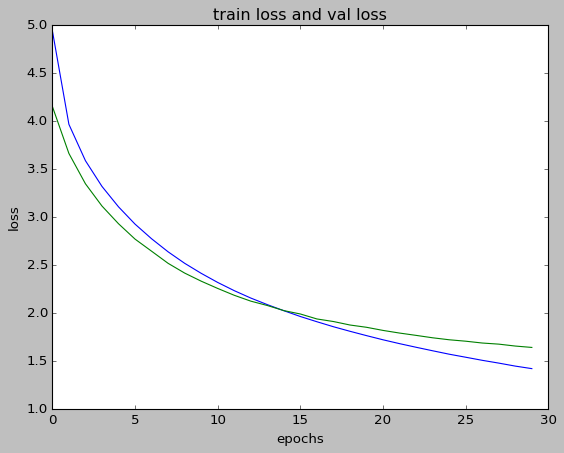

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('classic')

x = np.linspace(0, 10, 100)
plt.title("train loss and val loss")
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.xlabel("epochs")
plt.ylabel("loss")
print(val_losses)
plt.show()

In [ ]:
from torchtext.data.metrics import bleu_score

def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    # sentenct to tokens 
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # it is still a word list, not numerical list
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    # convert to token
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    # to tensor and set in cuda
    # (Batch_size(1), source_len)
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_s_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_t_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention


def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        # del <eos> token
        pred_trg = pred_trg[:-1]
        # 
        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

## BLEU Testing

In [ ]:
bleu_score = calculate_bleu(test_dataset, SRC, TRG, model, device)

print('BLEU score: {}'.format(bleu_score*100))

BLEU score: 30.88488280773163


## Attention Display

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 70

src = vars(train_dataset.examples[example_idx])['src']
trg = vars(train_dataset.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['why', 'were', 'you', 'holding', 'his', 'hand', '?']
trg = ['warum', 'hältst', 'du', 'seine', 'hand', '?']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['warum', 'warst', 'du', 'seine', 'hand', '?', '<eos>']


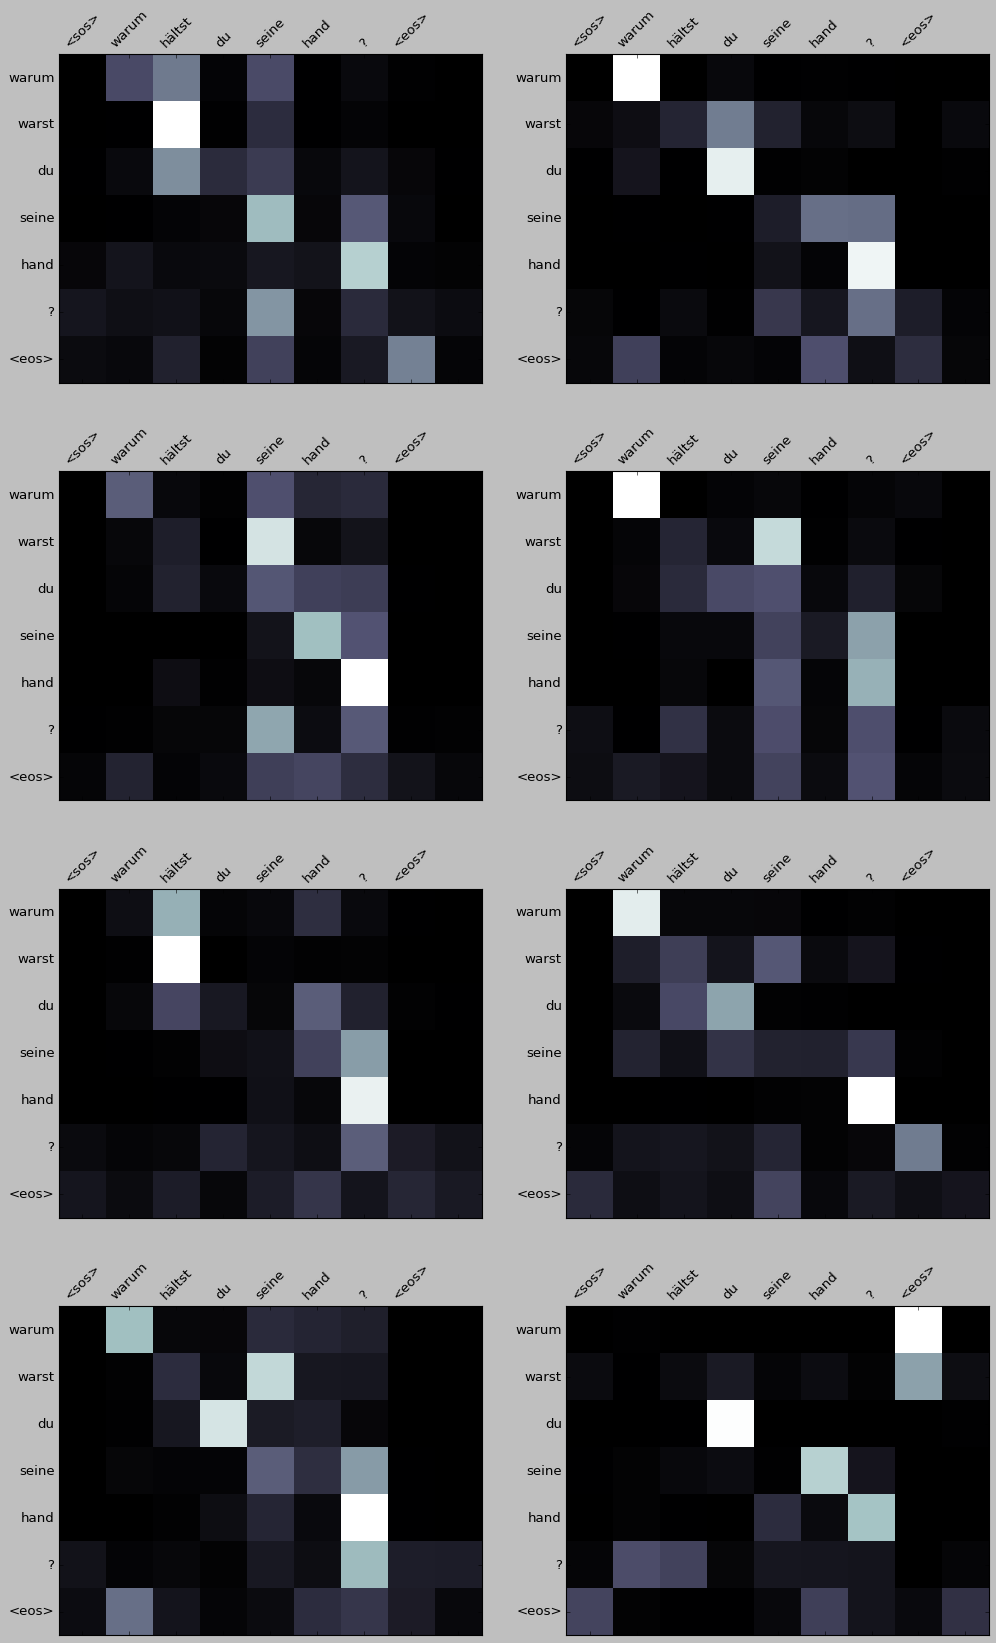

In [ ]:
display_attention(trg, translation, attention)